## MIT-BIH Database

The following steps are taken to predict PVCs in a 10-second frame EKG signal:
1. <a href='#link1'>Loading</a> and <a href='#link2'>splitting</a> of data into 10-second strips
2. <a href='#link3'>Extract information</a> from notes to determine if 10-second strips contain PVC, gender and age of patients
3. <a href='#link4'>Smoothing of signals</a>
    * Savitzky-Golay filter is the best filter out of the 3 filters tested
4. <a href='#link5'>Normalizing signals</a>
5. Feature extractions with <a href='#link6'>annotated information</a> and <a href='#link7'>Biosppy package</a>
6. <a href='#link8'>Modeling</a> 
    * Logistic Regression, Random Forest, Gradient Boosting Classifier, SVC
    * Using raw signals in CNN

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import wfdb
from tqdm import tqdm
from scipy import fftpack

### (Sample data) for Record #100

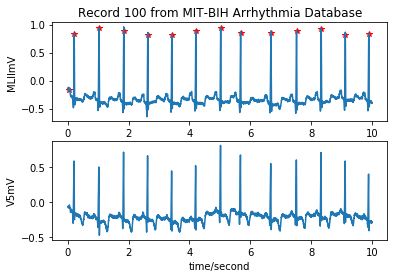

Raw signal for record #100 has 650000 data points.
[[-0.065]
 [-0.065]
 [-0.065]
 ...
 [-0.365]
 [-0.335]
 [ 0.   ]]

Details for record #100.
{'fs': 360, 'sig_len': 650000, 'n_sig': 1, 'base_date': None, 'base_time': None, 'units': ['mV'], 'sig_name': ['V5'], 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal']}


In [2]:
'''Read signal and details of Record 100'''

# plot record #100, from 0 to 10 seconds 
record100 = wfdb.rdrecord("100", pb_dir='mitdb', sampfrom=0, sampto=3600)
annotation100 = wfdb.rdann("100",'atr', pb_dir='mitdb', sampfrom=0, sampto=3600)

wfdb.plot_wfdb(record=record100, annotation=annotation100, title='Record 100 from MIT-BIH Arrhythmia Database',
               time_units='seconds')

# getting raw signals and annotations
signal100, field100 = wfdb.rdsamp('100', pb_dir='mitdb', channel_names=['V1','V2','V3','V4','V5'])
print("Raw signal for record #100 has {} data points.".format(len(signal100)))
print(signal100)
print("\nDetails for record #100.")
print(field100)

signals : numpy array - A 2d numpy array storing the physical signals from the record.
<br /> fields : dict - A dictionary containing several key attributes of the read record:
<br />
<br /> fs: The sampling frequency of the record
<br /> units: The units for each channel
<br /> sig_name: The signal name for each channel
<br /> comments: Any comments written in the header

In [3]:
'''Read ALL annotation of Record 100'''

# getting annotations at specific time stamps
annotation100 = wfdb.rdann('100', 'atr', pb_dir='mitdb', return_label_elements='symbol', summarize_labels=True)
symbol100 = annotation100.symbol   # from annotation.__dict__['symbol']
time100 = annotation100.sample
print(symbol100[:100])
print(time100)

['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
[    18     77    370 ... 649484 649734 649991]


In [4]:
wfdb.show_ann_labels()

    label_store symbol                                    description
0             0                              Not an actual annotation
1             1      N                                    Normal beat
2             2      L                  Left bundle branch block beat
3             3      R                 Right bundle branch block beat
4             4      a                Aberrated atrial premature beat
5             5      V              Premature ventricular contraction
6             6      F          Fusion of ventricular and normal beat
7             7      J              Nodal (junctional) premature beat
8             8      A                   Atrial premature contraction
9             9      S     Premature or ectopic supraventricular beat
10           10      E                        Ventricular escape beat
11           11      j                 Nodal (junctional) escape beat
12           12      /                                     Paced beat
13           13     

### Load all data from MIT-BIH
<a id='link1'></a>

In [5]:
'''Load records from https://physionet.org/physiobank/database/mitdb/'''

# list of files to load
all_files = list(range(100, 235, 1))

# Create function to convert field to dataframe
def create_df_field(input_file):
    
    df_field = pd.DataFrame()
    
    for i in tqdm(input_file):
        try:
            signal, field = wfdb.rdsamp(str(i), pb_dir='mitdb', channel_names=['V1','V2','V3','V4','V5'])
            df_field_single = pd.DataFrame.from_dict([field])
            df_field_single["File"] = str(i)
            annotation = wfdb.rdann(str(i), 'atr', pb_dir='mitdb', return_label_elements='symbol', summarize_labels=True)
            symbol = annotation.symbol
            time = annotation.sample
            df_field_single.loc[df_field_single["File"]==str(i), "annotation"] = [np.array([symbol],'object')]
            df_field_single.loc[df_field_single["File"]==str(i), "annotation_time"] = [np.array([time],'object')] 
            df_field_single.loc[df_field_single["File"]==str(i), "signal"] = [np.array(signal,'object')] 
            df_field = pd.concat([df_field, df_field_single], ignore_index=True)
        except:
            pass

    df_field = df_field.set_index("File", drop=True)
    df_field.drop(columns=['base_date','base_time'], inplace=True)
    df_field["Age"] = [int(i[0][:2]) for i in df_field["comments"]]
    df_field["Gender"] = [i[0][3:4] for i in df_field["comments"]]
    
    return df_field

In [6]:
df_field = create_df_field(all_files)

100%|████████████████████████████████████████████████████████████████████████████████| 135/135 [02:17<00:00,  2.27s/it]


In [7]:
df_field.head()

,comments,fs,n_sig,sig_len,sig_name,units,annotation,annotation_time,signal,Age,Gender
File,,,,,,,,,,,
100,"[69 M 1085 1629 x1, Aldomet, Inderal]",360,1,650000,[V5],[mV],"[[+, N, N, N, N, N, N, N, A, N, N, N, N, N, N,...","[[18, 77, 370, 662, 946, 1231, 1515, 1809, 204...","[[-0.065], [-0.065], [-0.065], [-0.065], [-0.0...",69,M
101,"[75 F 1011 654 x1, Diapres]",360,1,650000,[V1],[mV],"[[+, N, N, N, N, N, N, N, N, N, N, N, N, N, N,...","[[7, 83, 396, 711, 1032, 1368, 1712, 2036, 234...","[[-0.16], [-0.16], [-0.16], [-0.16], [-0.16], ...",75,F
102,"[84 F 1525 167 x1, Digoxin, The rhythm is pace...",360,2,650000,"[V2, V5]","[mV, mV]","[[+, /, /, /, /, /, /, /, /, /, /, /, /, /, /,...","[[68, 136, 410, 697, 989, 1305, 1614, 1911, 22...","[[0.005, -0.2], [0.005, -0.2], [0.005, -0.2], ...",84,F
103,"[-1 M 742 654 x1, Diapres, Xyloprim]",360,1,650000,[V2],[mV],"[[+, N, N, N, N, N, N, N, N, N, N, N, N, N, N,...","[[21, 265, 575, 876, 1180, 1482, 1795, 2127, 2...","[[0.05], [0.05], [0.05], [0.05], [0.05], [0.05...",-1,M
104,"[66 F 1567 694 x1, Digoxin, Pronestyl, The rat...",360,2,650000,"[V2, V5]","[mV, mV]","[[+, /, /, /, /, /, f, f, /, /, /, /, /, f, f,...","[[36, 73, 316, 615, 901, 1188, 1477, 1749, 206...","[[0.2, -0.15], [0.2, -0.15], [0.2, -0.15], [0....",66,F


In [8]:
df_field.index

Index(['100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
       '111', '112', '113', '114', '115', '116', '117', '118', '119', '121',
       '122', '123', '124', '200', '201', '202', '203', '205', '207', '208',
       '209', '210', '212', '213', '214', '215', '217', '219', '220', '221',
       '222', '223', '228', '230', '231', '232', '233', '234'],
      dtype='object', name='File')

### Slice V1 records into 10-seconds windows
<a id='link2'></a>

Text(0.5,0,'Time/sec')

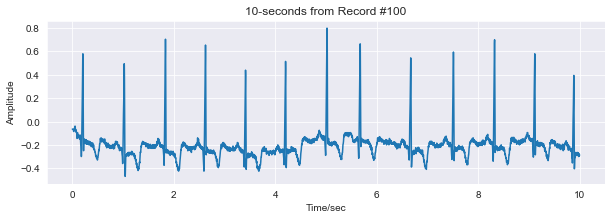

In [9]:
import seaborn as sns
sns.set_style('darkgrid')

# test first 10 seconds for record 100
signal_test = df_field.loc['100','signal']
y = signal_test[:3600]
x = np.arange(0,10,1/360)
plt.figure(figsize=(10,3))
plt.plot(x,y)
plt.title("10-seconds from Record #100")
plt.ylabel("Amplitude")
plt.xlabel("Time/sec")

In [10]:
'''Find files with V1 data'''

V1_files = []

for idx, record in df_field.iterrows():
    num_signals = record["n_sig"]
    sig_name = [record['sig_name'][i] for i in range(num_signals)]
    if 'V1' in sig_name:
        V1_files.append(idx)


<a id='link3'></a>

In [11]:
'''Create new df for V1 data'''

V1_df = pd.DataFrame({"File": V1_files})

for V1_file in V1_files:
    num_sig_count = df_field.loc[df_field.index== V1_file]['n_sig'][0]
    V1_df.loc[V1_df['File']== V1_file, 'annotation'] = [[df_field.loc[V1_file, 'annotation'][0]]]
    V1_df.loc[V1_df['File']== V1_file, 'annotation_time'] = [[df_field.loc[V1_file, 'annotation_time'][0]]]
    V1_df.loc[V1_df['File']== V1_file, 'age'] = df_field.loc[V1_file, 'Age']
    V1_df.loc[V1_df['File']== V1_file, 'gender'] = df_field.loc[V1_file, 'Gender']
    
    if num_sig_count == 1:
        V1_df.loc[V1_df['File']== V1_file, 'signal'] = [np.array([[i[0] for i in df_field.loc[V1_file,'signal']]],'object')]
    else:
        V1_idx = df_field.loc[V1_file,'sig_name'].index("V1")
        V1_df.loc[V1_df['File']== V1_file, 'signal'] = [np.array([[i[V1_idx] for i in df_field.loc[V1_file,'signal']]],
                                                                 'object')]

In [12]:
V1_df.head()

,File,annotation,annotation_time,age,gender,signal
0,101,"[[+, N, N, N, N, N, N, N, N, N, N, N, N, N, N,...","[[7, 83, 396, 711, 1032, 1368, 1712, 2036, 234...",75.0,F,"[[-0.16, -0.16, -0.16, -0.16, -0.16, -0.16, -0..."
1,105,"[[+, N, N, N, N, N, N, N, N, N, N, N, N, N, N,...","[[67, 197, 459, 708, 965, 1222, 1479, 1741, 20...",73.0,F,"[[0.26, 0.26, 0.26, 0.26, 0.26, 0.26, 0.26, 0...."
2,106,"[[~, +, N, N, N, N, N, N, N, N, N, N, N, N, N,...","[[83, 229, 351, 724, 1086, 1448, 1829, 2197, 2...",24.0,F,"[[0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0...."
3,107,"[[+, /, /, /, /, /, /, /, /, /, /, /, /, /, /,...","[[47, 95, 272, 569, 884, 1206, 1519, 1820, 211...",63.0,M,"[[-1.245, -1.245, -1.245, -1.245, -1.245, -1.2..."
4,108,"[[+, N, N, N, N, N, N, N, N, N, N, N, N, V, x,...","[[23, 88, 442, 789, 1155, 1493, 1821, 2157, 25...",87.0,F,"[[-0.78, -0.78, -0.78, -0.78, -0.78, -0.78, -0..."


In [13]:
# check if list has abnormal heartbeat
def isnorm(list):
    for i in list:
        if i != "N":
            return 0
    return 1

In [14]:
isnorm(["N","N","q","N"])

0

In [15]:
sliced_df = pd.DataFrame(columns=['signal','File','pvc_indicator','slice_num','time_signal'])

'''Slice signals, annotations and annotation times into 10-seconds windows (3600 data points each)
Mark records with PVC data'''
# each signal has 650000 data point (a total of 180 10-second strips)
# mark if every 3600 annotations, PVC exists

for idx, record in V1_df.iterrows():
    # slice signal into 10-second
    sliced_indiv_df = pd.DataFrame()
    sliced_signals = [record['signal'][0][i:i+3600] for i in np.arange(0, 650000, 3600)]
    sliced_indiv_df['signal'] = list(sliced_signals)
    sliced_indiv_df['File'] = record["File"]
    sliced_indiv_df['age'] = record["age"]
    sliced_indiv_df['gender'] = record["gender"]
    
    # indicate if 10-second window contains PVC
    PVC_indicator = []
    
    # indicate if 10-second window has abnormal heartbeat
    Normal_indicator = []
    
    for i in np.arange(0, 650000, 3600):
        time_list = [j for j in record['annotation_time'][0] if (j<=i+3600) & (j>i)]
        sliced_indiv_df.loc[int(i/3600), 'time_signal'] = [np.array([time_list],'object')]        
        idx_list = [list(record['annotation_time'][0]).index(j) for j in list(record['annotation_time'][0]) if (j>i) & (j<=i+3600)]

        if "V" in list(V1_df['annotation'][idx][0])[min(idx_list):max(idx_list)+1]:
            PVC_indicator.append(1)
        else:
            PVC_indicator.append(0)
            
        Normal_indicator.append(isnorm(list(V1_df['annotation'][idx][0])[min(idx_list):max(idx_list)+1]))
            

    slice_PVC_indicator = list(range(len(PVC_indicator)))
    sliced_indiv_df["pvc_indicator"] = PVC_indicator
    sliced_indiv_df["slice_num"] = slice_PVC_indicator
    sliced_indiv_df["norm_indicator"] = Normal_indicator
    
    sliced_df = pd.concat([sliced_df, sliced_indiv_df], axis=0, ignore_index=True, sort=False)

In [16]:
sliced_df.head()

,signal,File,pvc_indicator,slice_num,time_signal,age,gender,norm_indicator
0,"[-0.16, -0.16, -0.16, -0.16, -0.16, -0.16, -0....",101,0,0,"[[7, 83, 396, 711, 1032, 1368, 1712, 2036, 234...",75.0,F,0.0
1,"[-0.1, -0.11, -0.105, -0.105, -0.115, -0.12, -...",101,0,1,"[[3631, 3960, 4283, 4609, 4928, 5241, 5569, 58...",75.0,F,1.0
2,"[-0.105, -0.11, -0.095, -0.075, -0.08, -0.09, ...",101,0,2,"[[7463, 7786, 8105, 8414, 8721, 9026, 9321, 96...",75.0,F,1.0
3,"[-0.1, -0.125, -0.125, -0.1, -0.075, -0.09, -0...",101,0,3,"[[10892, 11185, 11470, 11760, 12050, 12338, 12...",75.0,F,1.0
4,"[-0.045, -0.055, -0.08, -0.09, -0.07, -0.075, ...",101,0,4,"[[14640, 14923, 15195, 15474, 15760, 16051, 16...",75.0,F,1.0


In [17]:
y = list(sliced_df["time_signal"][0][0])
x = [sliced_df["signal"][0][i] for i in y]

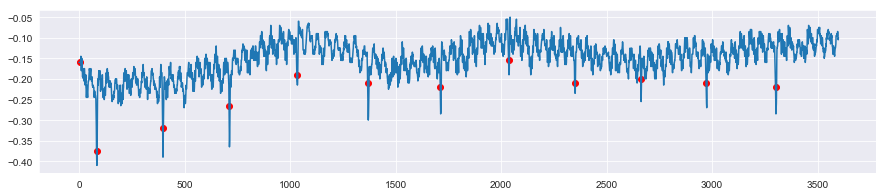

In [18]:
plt.figure(figsize=(15,3))
plt.plot(sliced_df["signal"][0])
plt.scatter(y, x, color='r')

In [19]:
# observe pvc vs non-pvc plot
sliced_df[sliced_df["pvc_indicator"]==1].head()

,signal,File,pvc_indicator,slice_num,time_signal,age,gender,norm_indicator
182,"[0.15, 0.135, 0.135, 0.145, 0.14, 0.145, 0.14,...",105,1,1,"[[3835, 4102, 4371, 4635, 4901, 5154, 5407, 55...",73.0,F,0.0
183,"[-0.01, -0.035, -0.045, -0.035, -0.025, -0.025...",105,1,2,"[[7246, 7506, 7767, 7922, 8290, 8564, 8829, 90...",73.0,F,0.0
184,"[0.06, 0.05, 0.045, 0.045, 0.05, 0.05, 0.04, 0...",105,1,3,"[[10908, 11168, 11424, 11676, 11931, 12187, 12...",73.0,F,0.0
186,"[0.16, 0.16, 0.14, 0.15, 0.15, 0.16, 0.16, 0.1...",105,1,5,"[[18168, 18426, 18682, 18946, 19213, 19483, 19...",73.0,F,0.0
187,"[0.1, 0.1, 0.08, 0.105, 0.13, 0.145, 0.125, 0....",105,1,6,"[[21838, 22100, 22351, 22604, 22860, 23114, 23...",73.0,F,0.0


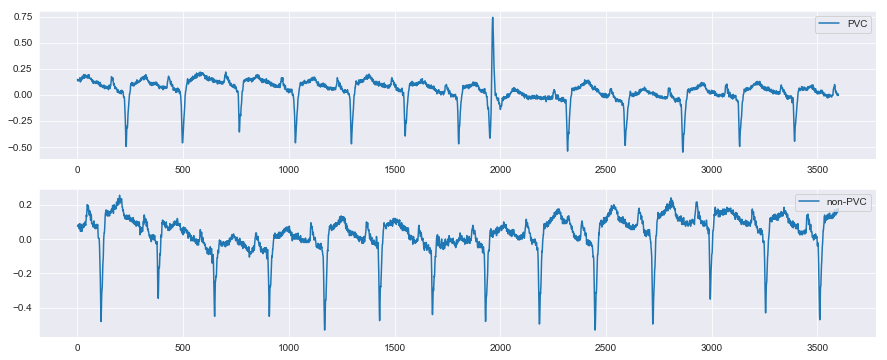

In [20]:
fig = plt.figure(figsize=(15,6))
ax1 = plt.subplot(211)
ax1.plot(sliced_df["signal"][182], label="PVC")
plt.legend(loc=1)
ax2 = plt.subplot(212)
ax2.plot(sliced_df["signal"][185], label="non-PVC")
plt.legend(loc=1)

### Smoothing of EKG signal
<a id='link4'></a>

#### 1) Fourier transform

In [ ]:
'''Fourier transform - DID NOT WORK THAT WELL'''
# find weights in fourier decomposition using FFT
# y = sliced_df["signal"][182]
# w = fftpack.rfft(y)
# spectrum = w**2

# # keep only terms of weight**2 > threshold 
# cutoff_idx = spectrum < (spectrum.max()/800)
# w2 = w.copy()
# w2[cutoff_idx] = 0

# # rebuild signal using inverse FFT 
# y2 = fftpack.irfft(w2)

# fig = plt.figure(figsize=(15,3))
# plt.plot(y)
# plt.plot(y2)

#### 2) Hamming

In [ ]:
# https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html

from numpy import *
from pylab import *
import numpy 
def smooth(x,window_len=15,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=numpy.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y

def smooth_demo():

    t=linspace(-4,4,100)
    x=sin(t)
    xn=x+randn(len(t))*0.1
    y=smooth(x)

if __name__=='__main__':
    smooth_demo()


In [ ]:
plot_smooth1 = smooth(sliced_df["signal"][1850][:500])
plt.figure(figsize=(15,3))
plt.plot(plot_smooth1, label="Smooth")
plt.plot(sliced_df["signal"][1850][:500], label="Raw")
plt.legend(loc=4)

#### 3) Savitzky-Golay filter

C:\Users\Wei Tan\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


(500,)


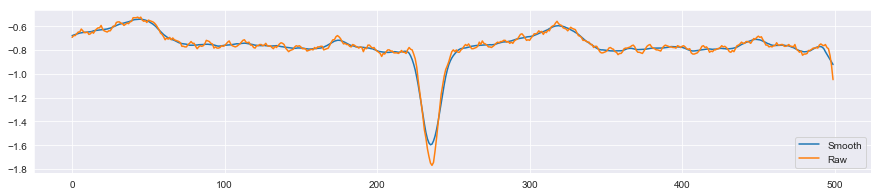

In [21]:
from scipy.signal import savgol_filter
sg_plot = savgol_filter(sliced_df["signal"][1850][:500], 11, 1)
plt.figure(figsize=(15,3))
print(sg_plot.shape)
plt.plot(sg_plot, label="Smooth")
plt.plot(sliced_df["signal"][1850][:500], label="Raw")
plt.legend(loc=4)

#### Use Savitzky-Golay filter for all records

In [22]:
sliced_df['smoothed_signal'] = [savgol_filter(sliced_df['signal'][i],11,1) for i in range(sliced_df.shape[0])]

C:\Users\Wei Tan\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [23]:
sliced_df.head()

,signal,File,pvc_indicator,slice_num,time_signal,age,gender,norm_indicator,smoothed_signal
0,"[-0.16, -0.16, -0.16, -0.16, -0.16, -0.16, -0....",101,0,0,"[[7, 83, 396, 711, 1032, 1368, 1712, 2036, 234...",75.0,F,0.0,"[-0.16045454545454535, -0.16009090909090898, -..."
1,"[-0.1, -0.11, -0.105, -0.105, -0.115, -0.12, -...",101,0,1,"[[3631, 3960, 4283, 4609, 4928, 5241, 5569, 58...",75.0,F,1.0,"[-0.1052272727272727, -0.10627272727272724, -0..."
2,"[-0.105, -0.11, -0.095, -0.075, -0.08, -0.09, ...",101,0,2,"[[7463, 7786, 8105, 8414, 8721, 9026, 9321, 96...",75.0,F,1.0,"[-0.09522727272727267, -0.09618181818181813, -..."
3,"[-0.1, -0.125, -0.125, -0.1, -0.075, -0.09, -0...",101,0,3,"[[10892, 11185, 11470, 11760, 12050, 12338, 12...",75.0,F,1.0,"[-0.10477272727272723, -0.10581818181818177, -..."
4,"[-0.045, -0.055, -0.08, -0.09, -0.07, -0.075, ...",101,0,4,"[[14640, 14923, 15195, 15474, 15760, 16051, 16...",75.0,F,1.0,"[-0.06204545454545453, -0.06445454545454544, -..."


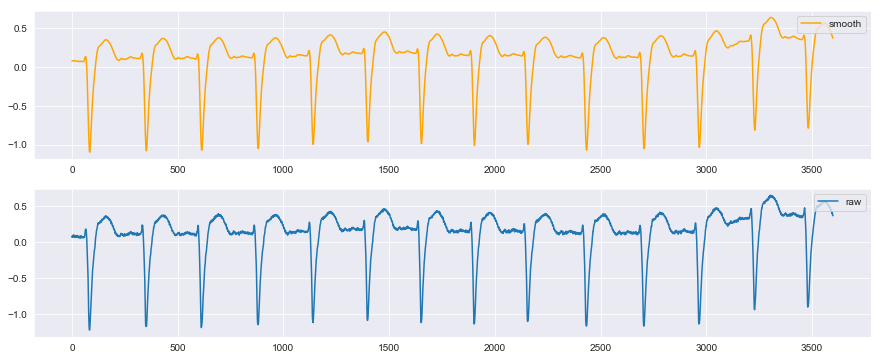

In [24]:
# check
plt.figure(figsize=(15,6))
ax1 = plt.subplot(211)
ax1.plot(sliced_df["smoothed_signal"][1000], label="smooth", c='orange')
plt.legend(loc=1)
ax2 = plt.subplot(212)
ax2.plot(sliced_df["signal"][1000], label="raw")
plt.legend(loc=1)

### Normalizing signals
<a id='link5'></a>

In [25]:
def normalize(timeseries):
    max_val = timeseries.max()
    if max_val:
        return timeseries/max_val
    else:
        return np.zeros(len(timeseries))

In [26]:
norm_signal = normalize(sliced_df["smoothed_signal"][1000])

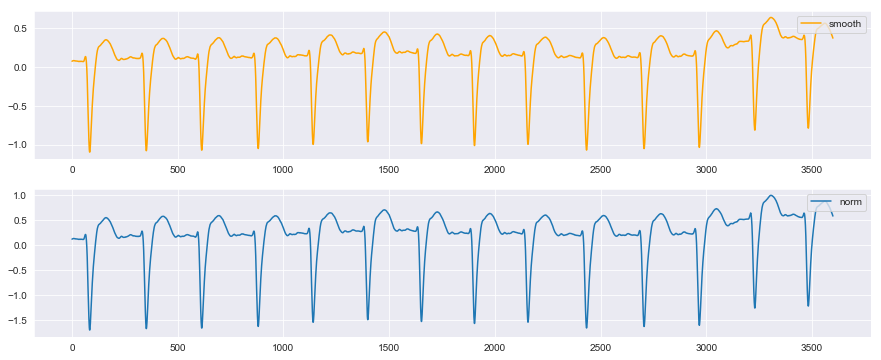

In [27]:
plt.figure(figsize=(15,6))
ax1 = plt.subplot(211)
ax1.plot(sliced_df["smoothed_signal"][1000], label="smooth", c='orange')
plt.legend(loc=1)
ax2 = plt.subplot(212)
ax2.plot(norm_signal, label="norm")
plt.legend(loc=1)

In [28]:
# normalize all signals
sliced_df['norm_signal'] = [normalize(row['smoothed_signal']) for idx, row in sliced_df.iterrows()]

In [29]:
len(sliced_df["norm_signal"][0])

3600

### More features extraction
<a id='link6'></a>

In [30]:
# average and std of time between peak-to-peak
for idx, row in sliced_df.iterrows():
    p2p_dist = [row["time_signal"][0][i+1] - row["time_signal"][0][i] for i in range(len(row["time_signal"][0])-1)]
    sliced_df.loc[idx,'mean_p2p'] = np.mean(p2p_dist)
    sliced_df.loc[idx,'std_p2p'] = np.std(p2p_dist)

In [31]:
len(set(sliced_df["File"]))

40

In [32]:
# average and std of height of peaks
unique_files = len(set(sliced_df["File"]))
files_processed = 0

for file in range(unique_files):
#     print(file)
    for i in range(181):
        signal_idx = sliced_df["time_signal"][i][0]
        signal_idx = [idx-i*3600 for idx in signal_idx]
        highest_signals = [np.mean(sliced_df["norm_signal"][i][high_idx-5:high_idx+10]) for high_idx in signal_idx]
        sliced_df.loc[file*181+i, 'mean_high'] = np.mean(highest_signals)
        sliced_df.loc[file*181+i, 'std_high'] = np.std(highest_signals)


In [33]:
sliced_df.head()

,signal,File,pvc_indicator,slice_num,time_signal,age,gender,norm_indicator,smoothed_signal,norm_signal,mean_p2p,std_p2p,mean_high,std_high
0,"[-0.16, -0.16, -0.16, -0.16, -0.16, -0.16, -0....",101,0,0,"[[7, 83, 396, 711, 1032, 1368, 1712, 2036, 234...",75.0,F,0.0,"[-0.16045454545454535, -0.16009090909090898, -...","[2.3071895424836595, 2.301960784313725, 2.2967...",299.454545,71.410928,2.759579,0.645551
1,"[-0.1, -0.11, -0.105, -0.105, -0.115, -0.12, -...",101,0,1,"[[3631, 3960, 4283, 4609, 4928, 5241, 5569, 58...",75.0,F,1.0,"[-0.1052272727272727, -0.10627272727272724, -0...","[-3.795081967213115, -3.8327868852459015, -3.8...",319.272727,9.235218,-4.392623,1.086650
2,"[-0.105, -0.11, -0.095, -0.075, -0.08, -0.09, ...",101,0,2,"[[7463, 7786, 8105, 8414, 8721, 9026, 9321, 96...",75.0,F,1.0,"[-0.09522727272727267, -0.09618181818181813, -...","[5.985714285714283, 6.045714285714284, 6.10571...",312.700000,9.980481,8.375758,2.080524
3,"[-0.1, -0.125, -0.125, -0.1, -0.075, -0.09, -0...",101,0,3,"[[10892, 11185, 11470, 11760, 12050, 12338, 12...",75.0,F,1.0,"[-0.10477272727272723, -0.10581818181818177, -...","[-6.065789473684209, -6.126315789473683, -6.18...",286.750000,7.949057,-6.886100,2.138047
4,"[-0.045, -0.055, -0.08, -0.09, -0.07, -0.075, ...",101,0,4,"[[14640, 14923, 15195, 15474, 15760, 16051, 16...",75.0,F,1.0,"[-0.06204545454545453, -0.06445454545454544, -...","[3.5921052631578942, 3.7315789473684213, 3.871...",288.545455,9.764161,8.902632,2.334803


## Biosppy signal processing
<a id='link7'></a>

In [34]:
from biosppy.signals.ecg import ecg

In [35]:
# example
test_ecg = ecg(sliced_df["norm_signal"][1000], sampling_rate=360, show=False)

C:\Users\Wei Tan\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\Wei Tan\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\Wei Tan\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array

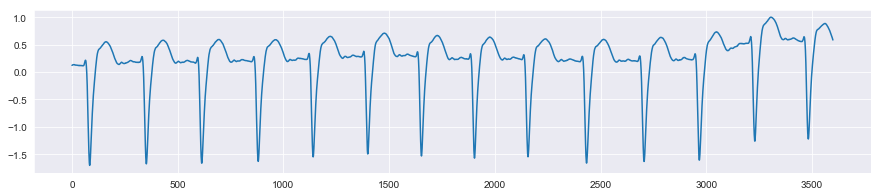

In [36]:
plt.figure(figsize=(15,3))
plt.plot(sliced_df["norm_signal"][1000])

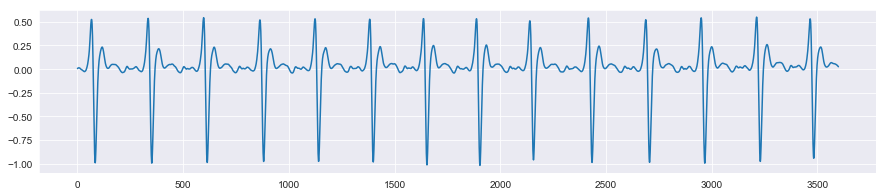

In [37]:
plt.figure(figsize=(15,3))
plt.plot(test_ecg["filtered"])

In [38]:
# some useful features
test_ecg["heart_rate"]

array([81.82052088, 82.03030192, 82.56085281, 83.72847776, 84.94227086,
       85.49379214, 83.34545455, 81.01604278, 80.03846079, 81.4324203 ,
       82.44274809])

In [39]:
# some useful features
R_points = test_ecg["rpeaks"]

In [40]:
# perform biosppy filters and feature extraction for the records
for idx, rows in sliced_df.iterrows():
#     print(idx)
    biosppy_filtered = ecg(rows["norm_signal"], sampling_rate=360, show=False)
    filtered_signals = biosppy_filtered["filtered"]
    # filtered signals
    sliced_df.loc[idx, "bio_min"] = np.min(filtered_signals)
    sliced_df.loc[idx, "bio_max"] = np.max(filtered_signals)
    sliced_df.loc[idx, "bio_std"] = np.std(filtered_signals)
    filtered_heartrate = biosppy_filtered["heart_rate"]
#     print(filtered_heartrate)
    
    # heartrate
    if filtered_heartrate != []:
        sliced_df.loc[idx, "bio_mean_HR"] = np.mean(filtered_heartrate)
        sliced_df.loc[idx, "bio_max_HR"] = np.max(filtered_heartrate)
        sliced_df.loc[idx, "bio_min_HR"] = np.min(filtered_heartrate)
        sliced_df.loc[idx, "bio_std_HR"] = np.std(filtered_heartrate)
    else:
        sliced_df.loc[idx, "bio_mean_HR"] = 0
        sliced_df.loc[idx, "bio_max_HR"] = 0
        sliced_df.loc[idx, "bio_min_HR"] = 0
        sliced_df.loc[idx, "bio_std_HR"] = 0
        
    # r peak positions and signal values
    R_points = biosppy_filtered["rpeaks"]
    rpeaks = np.array([filtered_signals[i] for i in R_points])
    sliced_df.loc[idx, "bio_mean_rpeaks"] = np.mean(rpeaks)
    sliced_df.loc[idx, "bio_min_rpeaks"] = np.min(rpeaks)
    sliced_df.loc[idx, "bio_max_rpeaks"] = np.max(rpeaks)
    sliced_df.loc[idx, "bio_std_rpeaks"] = np.std(rpeaks)
    peak_diff = np.diff(np.array(rpeaks))
    rpoints_diff = np.diff(np.array(R_points))
    sliced_df.loc[idx, "bio_stdpeakdiff"] = np.std(peak_diff)
    sliced_df.loc[idx, "bio_stdrpointsdiff"] = np.std(rpoints_diff)
    sliced_df.loc[idx, "bio_avgpeakdiff"] = np.mean(peak_diff)
    sliced_df.loc[idx, "bio_avgrpointsdiff"] = np.mean(rpoints_diff)
    sliced_df.loc[idx, "bio_min_rpointsdiff"] = np.min(rpoints_diff)
    sliced_df.loc[idx, "bio_max_rpointsdiff"] = np.max(rpoints_diff)
    
#     break

C:\Users\Wei Tan\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\Wei Tan\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\Wei Tan\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array

In [41]:
sliced_df["gender"] = sliced_df["gender"].map({"F":0, "M":1})

In [42]:
sliced_df["pvc_indicator"] = sliced_df["pvc_indicator"].astype("int")

In [43]:
sliced_df.head()

,signal,File,pvc_indicator,slice_num,time_signal,age,gender,norm_indicator,smoothed_signal,norm_signal,...,bio_mean_rpeaks,bio_min_rpeaks,bio_max_rpeaks,bio_std_rpeaks,bio_stdpeakdiff,bio_stdrpointsdiff,bio_avgpeakdiff,bio_avgrpointsdiff,bio_min_rpointsdiff,bio_max_rpointsdiff
0,"[-0.16, -0.16, -0.16, -0.16, -0.16, -0.16, -0....",101,0,0,"[[7, 83, 396, 711, 1032, 1368, 1712, 2036, 234...",75.0,0,0.0,"[-0.16045454545454535, -0.16009090909090898, -...","[2.3071895424836595, 2.301960784313725, 2.2967...",...,0.712384,0.415853,1.191556,0.266146,0.416706,90.258310,-0.003366,201.250000,39.0,341.0
1,"[-0.1, -0.11, -0.105, -0.105, -0.115, -0.12, -...",101,0,1,"[[3631, 3960, 4283, 4609, 4928, 5241, 5569, 58...",75.0,0,1.0,"[-0.1052272727272727, -0.10627272727272724, -0...","[-3.795081967213115, -3.8327868852459015, -3.8...",...,0.991521,0.719306,1.431405,0.226060,0.348335,67.601570,-0.030091,178.294118,82.0,306.0
2,"[-0.105, -0.11, -0.095, -0.075, -0.08, -0.09, ...",101,0,2,"[[7463, 7786, 8105, 8414, 8721, 9026, 9321, 96...",75.0,0,1.0,"[-0.09522727272727267, -0.09618181818181813, -...","[5.985714285714283, 6.045714285714284, 6.10571...",...,2.572970,1.706273,4.970188,0.924085,1.559539,72.527167,0.034180,155.100000,46.0,308.0
3,"[-0.1, -0.125, -0.125, -0.1, -0.075, -0.09, -0...",101,0,3,"[[10892, 11185, 11470, 11760, 12050, 12338, 12...",75.0,0,1.0,"[-0.10477272727272723, -0.10581818181818177, -...","[-6.065789473684209, -6.126315789473683, -6.18...",...,1.366472,0.635890,2.201352,0.396823,0.601207,58.909389,-0.025313,149.954545,40.0,280.0
4,"[-0.045, -0.055, -0.08, -0.09, -0.07, -0.075, ...",101,0,4,"[[14640, 14923, 15195, 15474, 15760, 16051, 16...",75.0,0,1.0,"[-0.06204545454545453, -0.06445454545454544, -...","[3.5921052631578942, 3.7315789473684213, 3.871...",...,3.622904,1.905909,4.829783,0.669104,0.910178,9.902834,0.066023,288.545455,270.0,304.0


### Randomly selection of testing data
40 files in total, each with 181 rows

In [44]:
# remove last chunk of signal that only has 2000 signals
remove_idx = [idx for idx, row in sliced_df.iterrows() if len(row["norm_signal"])!=3600]

In [45]:
sliced_df.drop(index=remove_idx, inplace=True)

In [46]:
sliced_df.shape

(7200, 31)

In [47]:
# randomly select rows
import random
random.seed(2019)
train_idx = random.sample(range(0,sliced_df.shape[0]), int(sliced_df.shape[0]*0.85), )
# print(train_idx[:10])
train_df = sliced_df.iloc[train_idx,:]
train_df.head()

,signal,File,pvc_indicator,slice_num,time_signal,age,gender,norm_indicator,smoothed_signal,norm_signal,...,bio_mean_rpeaks,bio_min_rpeaks,bio_max_rpeaks,bio_std_rpeaks,bio_stdpeakdiff,bio_stdrpointsdiff,bio_avgpeakdiff,bio_avgrpointsdiff,bio_min_rpointsdiff,bio_max_rpointsdiff
6855,"[-0.05, -0.05, -0.055, -0.075, -0.06, -0.075, ...",232,0,158,"[[569035, 569923, 570474, 570731, 571009, 5712...",76.0,0,0.0,"[-0.058409090909090876, -0.059181818181818155,...","[-0.11986940298507458, -0.12145522388059699, -...",...,0.531996,0.477937,0.580484,0.032972,0.040259,211.342140,-0.003309,384.000000,260.0,889.0
1273,"[-0.665, -0.66, -0.675, -0.675, -0.685, -0.72,...",112,0,6,"[[21601, 21858, 22109, 22367, 22611, 22865, 23...",54.0,1,1.0,"[-0.675, -0.6786363636363637, -0.6822727272727...","[2.1428571428571437, 2.1544011544011554, 2.165...",...,0.430927,0.380173,0.497303,0.033994,0.036320,4.853407,0.007668,251.333333,245.0,258.0
6497,"[0.055, 0.03, 0.015, 0.07, 0.115, 0.185, 0.215...",230,0,162,"[[583331, 583580, 583826, 584066, 584309, 5845...",32.0,1,1.0,"[0.061590909090909064, 0.07054545454545452, 0....","[0.08379715522572663, 0.09598021026592454, 0.1...",...,0.643892,0.577505,0.694147,0.035521,0.038789,5.399978,0.005971,248.615385,240.0,257.0
1995,"[-0.4, -0.39, -0.41, -0.455, -0.465, -0.5, -0....",118,0,4,"[[14638, 14916, 15209, 15497, 15789, 16090, 16...",69.0,1,0.0,"[-0.4061363636363633, -0.4197272727272724, -0....","[-1.005061867266591, -1.0386951631046113, -1.0...",...,1.856235,1.693914,1.977529,0.090259,0.098351,9.542012,-0.027729,298.500000,279.0,309.0
4094,"[0.215, 0.22, 0.245, 0.26, 0.27, 0.295, 0.305,...",209,0,112,"[[403213, 403437, 403655, 403856, 404113, 4043...",62.0,1,1.0,"[0.22249999999999998, 0.23418181818181816, 0.2...","[0.7125181950509463, 0.7499272197962156, 0.787...",...,0.356799,0.278555,0.502353,0.060174,0.064329,16.434316,0.012827,228.642857,202.0,261.0


In [48]:
test_idx = list(set(range(0,sliced_df.shape[0])) - set(train_idx))
# val_idx = random.sample(left_idx, int(sliced_df.shape[0]*0.15))
# test_idx = list(set(left_idx) - set(val_idx))

test_df = sliced_df.iloc[test_idx,:]

# test_df = sliced_df.iloc[test_idx,:]

In [ ]:
import gc 
del df_field, V1_df, V1_file, V1_files
gc.collect()

In [49]:
print("shape of training set : " + str(train_df.shape))
print("shape of testing set : " + str(test_df.shape))
# print("shape of validation set : " + str(val_df.shape))

shape of training set : (6120, 31)
shape of testing set : (1080, 31)


In [50]:
list(train_df.columns)

['signal',
 'File',
 'pvc_indicator',
 'slice_num',
 'time_signal',
 'age',
 'gender',
 'norm_indicator',
 'smoothed_signal',
 'norm_signal',
 'mean_p2p',
 'std_p2p',
 'mean_high',
 'std_high',
 'bio_min',
 'bio_max',
 'bio_std',
 'bio_mean_HR',
 'bio_max_HR',
 'bio_min_HR',
 'bio_std_HR',
 'bio_mean_rpeaks',
 'bio_min_rpeaks',
 'bio_max_rpeaks',
 'bio_std_rpeaks',
 'bio_stdpeakdiff',
 'bio_stdrpointsdiff',
 'bio_avgpeakdiff',
 'bio_avgrpointsdiff',
 'bio_min_rpointsdiff',
 'bio_max_rpointsdiff']

In [51]:
feats = ['age', 
         'gender',
        'mean_p2p',
        'std_p2p',
        'mean_high',
        'std_high',
        'bio_min',
        'bio_max',
        'bio_mean_HR',
        'bio_max_HR',
        'bio_min_HR',
        'bio_std',
        'bio_std_HR',
        'bio_mean_rpeaks',
        'bio_min_rpeaks',
        'bio_max_rpeaks',
        'bio_std_rpeaks',
        'bio_avgpeakdiff',
        'bio_avgrpointsdiff',
        'bio_stdpeakdiff',
        'bio_stdrpointsdiff',
        'bio_min_rpointsdiff',
        'bio_max_rpointsdiff']

In [52]:
train_X = train_df[feats]
train_y = train_df["pvc_indicator"]
test_X = test_df[feats]
test_y = test_df["pvc_indicator"]

## Modeling
<a id='link8'></a>

In [53]:
from sklearn.model_selection import GridSearchCV

def algorithm_run(parameters, classifier, X, y):
    grid = GridSearchCV(classifier, parameters, scoring="roc_auc")
    grid.fit(X, y)
    bestparams = grid.best_params_
    bestscore = grid.best_score_
    print(bestparams, bestscore)
    return bestparams, bestscore

In [89]:
all_results = pd.DataFrame(columns=["roc_auc", "accuracy", "precision", "recall"])

### Logistic Regression

In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [91]:
lr_parameters = {"penalty" : ["l1", "l2"],
            "C" : np.logspace(0,4,10)}

lr_bestparams, lr_bestscore = algorithm_run(lr_parameters, LogisticRegression(), train_X, train_y)

lr = LogisticRegression(**lr_bestparams)
lr.fit(train_X, train_y)
lr_score = lr.score(train_X, train_y)

{'C': 1.0, 'penalty': 'l1'} 0.8853366942137257


In [92]:
lr_predictions = lr.predict(test_X)
lr_results = pd.DataFrame(confusion_matrix(test_y, lr_predictions),
             columns = ["Predicted Negative", "Predicted Positive"],
            index = ["Actual False", "Actual True"])
lr_results

,Predicted Negative,Predicted Positive
Actual False,642,93
Actual True,122,223


In [93]:
lr_predictions

array([1, 0, 0, ..., 0, 0, 0])

In [94]:
tn, fp, fn, tp = confusion_matrix(test_y, lr_predictions).ravel()
tn, fp, fn, tp

(642, 93, 122, 223)

In [95]:
lr_acc = (tp+tn)/(tp+tn+fn+fp)
lr_recall = (tp)/(tp+fp)
lr_precision = (tp)/(tp+fn)
lr_sensitivity = (tp)/(tp+fn)
lr_specificity = (tn)/(tn+fp)
print("Logistic Regression has {:.3f} accuracy, {:.3f} recall and {:.3f} precision.".format(lr_acc, lr_recall, lr_precision))
print("Logistic Regression has {:.3f} sensitivity and {:.3f} specificity.".format(lr_sensitivity, lr_specificity))

Logistic Regression has 0.801 accuracy, 0.706 recall and 0.646 precision.
Logistic Regression has 0.646 sensitivity and 0.873 specificity.


In [96]:
from sklearn.metrics import roc_auc_score

lr_rocauc = roc_auc_score(test_y, lr_predictions)
lr_rocauc

0.7599230996746525

### Random forest

In [97]:
from sklearn.ensemble import RandomForestClassifier

C:\Users\Wei Tan\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [98]:
rf_parameters = {"n_estimators" : [2, 3, 5, 10], 
                 "criterion" : ["gini", "entropy"], 
                 "max_depth" : [5, 6, 8], 
                 "min_samples_split" : [2, 3, 4, 5], 
                 "min_samples_leaf" : [2, 3, 4],
                 "random_state" : [2019]
             }

rf_bestparams, rf_bestscore = algorithm_run(rf_parameters, RandomForestClassifier(), train_X, train_y )
                    
rf = RandomForestClassifier(**rf_bestparams)
rf.fit(train_X, train_y)
rf_score = rf.score(train_X, train_y)

{'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10, 'random_state': 2019} 0.979183858397641


In [99]:
rf_predictions = rf.predict(test_X)
rf_results = pd.DataFrame(confusion_matrix(test_y, rf_predictions),
             columns = ["Predicted Negative", "Predicted Positive"],
            index = ["Actual False", "Actual True"])
rf_results

,Predicted Negative,Predicted Positive
Actual False,697,38
Actual True,27,318


In [100]:
tn, fp, fn, tp = confusion_matrix(test_y, rf_predictions).ravel()
rf_acc = (tp+tn)/(tp+tn+fn+fp)
rf_recall = (tp)/(tp+fp)
rf_precision = (tp)/(tp+fn)
rf_sensitivity = (tp)/(tp+fn)
rf_specificity = (tn)/(tn+fp)
print("Random forest has {:.3f} accuracy, {:.3f} recall and {:.3f} precision.".format(rf_acc, rf_recall, rf_precision))
print("Random forest has {:.3f} sensitivity and {:.3f} specificity.".format(rf_sensitivity, rf_specificity))

Random forest has 0.940 accuracy, 0.893 recall and 0.922 precision.
Random forest has 0.922 sensitivity and 0.948 specificity.


In [101]:
rf_rocauc = roc_auc_score(test_y, rf_predictions)
rf_rocauc

0.935019225081337

### Gradient boosting Classifier

In [102]:
from sklearn.ensemble import GradientBoostingClassifier

In [103]:
gbc_parameters = {"learning_rate" : [0.02, 0.05, 0.1],
                  "max_depth" : [4, 6, 8],
                  "max_features" : [1.0, 0.3, 0.1], 
                  "min_samples_split" : [2, 3, 4],
                  "random_state" : [2019]
             }

gbc_bestparams, gbc_bestscore = algorithm_run(gbc_parameters, GradientBoostingClassifier(), train_X, train_y)
                    
gbc = GradientBoostingClassifier(**gbc_bestparams)
gbc.fit(train_X, train_y)
gbc_score = gbc.score(train_X, train_y)

{'learning_rate': 0.1, 'max_depth': 8, 'max_features': 0.3, 'min_samples_split': 3, 'random_state': 2019} 0.9904781160023837


In [104]:
gbc_predictions = gbc.predict(test_X)
gbc_results = pd.DataFrame(confusion_matrix(test_y, gbc_predictions),
             columns = ["Predicted Negative", "Predicted Positive"],
            index = ["Actual False", "Actual True"])
gbc_results

,Predicted Negative,Predicted Positive
Actual False,713,22
Actual True,20,325


In [105]:
tn, fp, fn, tp = confusion_matrix(test_y, gbc_predictions).ravel()
gbc_acc = (tp+tn)/(tp+tn+fn+fp)
gbc_recall = (tp)/(tp+fp)
gbc_precision = (tp)/(tp+fn)
gbc_sensitivity = (tp)/(tp+fn)
gbc_specificity = (tn)/(tn+fp)
print("GradientBoostingClassifier has {:.3f} accuracy, {:.3f} recall and {:.3f} precision.".format(gbc_acc, gbc_recall, gbc_precision))
print("GradientBoostingClassifier has {:.3f} sensitivity and {:.3f} specificity.".format(gbc_sensitivity, gbc_specificity))

GradientBoostingClassifier has 0.961 accuracy, 0.937 recall and 0.942 precision.
GradientBoostingClassifier has 0.942 sensitivity and 0.970 specificity.


In [106]:
gbc_rocauc = roc_auc_score(test_y, gbc_predictions)
gbc_rocauc

0.9560485063590654

### SVC

In [54]:
from sklearn.svm import SVC

In [85]:
# svc_parameters = svc_params = {'C': [1, 3, 5], 
#               'kernel': ['linear','rbf']}
#               'gamma': [0.00001, 0.0001, 0.001, 0.01]}

# svc_bestparams, svc_bestscore = algorithm_run(svc_parameters, SVC(), train_X, train_y)

# svc = SVC(**svc_bestparams)


svc = SVC(C=1.0, kernel='rbf', gamma=0.0001)
svc.fit(train_X, train_y)
svc_score = svc.score(train_X, train_y)

In [86]:
svc_predictions = svc.predict(test_X)
svc_results = pd.DataFrame(confusion_matrix(test_y, svc_predictions),
             columns = ["Predicted Negative", "Predicted Positive"],
            index = ["Actual False", "Actual True"])
svc_results

,Predicted Negative,Predicted Positive
Actual False,672,63
Actual True,51,294


In [87]:
tn, fp, fn, tp = confusion_matrix(test_y, svc_predictions).ravel()
svc_acc = (tp+tn)/(tp+tn+fn+fp)
svc_recall = (tp)/(tp+fp)
svc_precision = (tp)/(tp+fn)
svc_sensitivity = (tp)/(tp+fn)
svc_specificity = (tn)/(tn+fp)
print("SVC has {:.3f} accuracy, {:.3f} recall and {:.3f} precision.".format(svc_acc, svc_recall, svc_precision))
print("SVC has {:.3f} sensitivity and {:.3f} specificity.".format(svc_sensitivity, svc_specificity))

SVC has 0.894 accuracy, 0.824 recall and 0.852 precision.
SVC has 0.852 sensitivity and 0.914 specificity.


In [88]:
svc_rocauc = roc_auc_score(test_y, svc_predictions)
svc_rocauc

0.8832298136645962

### 1D CNN model using raw EKG data

In [107]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv1D, Dropout, MaxPooling1D, GlobalAveragePooling1D

C:\Users\Wei Tan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [108]:
features = ['norm_signal']

In [109]:
train_df["pvc_indicator"].value_counts()

0    4143
1    1977
Name: pvc_indicator, dtype: int64

In [110]:
X_train_df = train_df[features]
y_train_df = train_df["pvc_indicator"]
X_test_df = test_df[features]
y_test_df = test_df["pvc_indicator"]

In [111]:
X_train_df.shape

(6120, 1)

In [112]:
y_train = np.array(y_train_df)
y_test = np.array(y_test_df)

In [113]:
# replace this with train
X_train = []
for i in X_train_df["norm_signal"]:
    X_train += list(i)
    
X_train = np.array(X_train).reshape(X_train_df.shape[0], 3600, 1)

In [ ]:
# X_valid = []
# for i in X_valid_df["norm_signal"]:
#     X_valid += list(i)
    
# X_valid = np.array(X_valid).reshape(X_valid_df.shape[0], 3600, 1)

In [114]:
X_test = []
for i in X_test_df["norm_signal"]:
    X_test += list(i)
    
X_test = np.array(X_test).reshape(X_test_df.shape[0], 3600, 1)

y_test = np.array(y_test_df)

In [115]:
X_train.shape

(6120, 3600, 1)

In [121]:
# nb_features = X_train.shape[1]
# nb_class = 1

# model = Sequential()
# model.add(Conv1D(filters=256, kernel_size=4, input_shape=(nb_features, 1)))
# # model.add(Activation('relu'))
# model.add(Conv1D(filters=128, kernel_size=4, input_shape=(nb_features, 1)))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Dropout(rate=0.1))
# model.add(Conv1D(filters=128, kernel_size=4, input_shape=(nb_features, 1)))
# model.add(Conv1D(filters=128, kernel_size=4, input_shape=(nb_features, 1)))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Dropout(rate=0.1))
# # model.add(Activation('relu'))
# # model.add(Flatten())
# model.add(Dropout(0.1))
# model.add(Dense(2048, activation='relu'))
# model.add(Dense(1024, activation='relu'))
# model.add(Dense(512, activation='relu'))
# model.add(GlobalAveragePooling1D())
# model.add(Dense(units=nb_class, activation='sigmoid'))

# print(model.summary())


In [119]:
nb_features = X_train.shape[1]
nb_class = 1

model = Sequential()
model.add(Conv1D(filters=128, kernel_size=1, input_shape=(nb_features, 1)))
model.add(Activation('relu'))
model.add(Conv1D(filters=128, kernel_size=1, input_shape=(nb_features, 1)))
model.add(Activation('relu'))
# model.add(Flatten())
model.add(Dropout(0.3))
# model.add(Dense(2048, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dense(units=nb_class, activation='sigmoid'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 3600, 128)         256       
_________________________________________________________________
activation_1 (Activation)    (None, 3600, 128)         0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 3600, 128)         16512     
_________________________________________________________________
activation_2 (Activation)    (None, 3600, 128)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 3600, 128)         0         
_________________________________________________________________
dense_5 (Dense)              (None, 3600, 1024)        132096    
_________________________________________________________________
dense_6 (Dense)              (None, 3600, 512)         524800    
__________

In [ ]:
# from keras import backend as K

# def precision(y_true, y_pred):
#     """Precision metric.
#     Only computes a batch-wise average of precision.
#     Computes the precision, a metric for multi-label classification of
#     how many selected items are relevant.
#     """
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     return precision

# def recall(y_true, y_pred):
#     """Recall metric.
#     Only computes a batch-wise average of recall.
#     Computes the recall, a metric for multi-label classification of
#     how many relevant items are selected.
#     """
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     recall = true_positives / (possible_positives + K.epsilon())
#     return recall

In [120]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

nb_epoch = 2
model.fit(X_train, y_train, epochs=nb_epoch, batch_size=50, verbose=1)
# model.fit(X_train, y_train, epochs=nb_epoch, validation_data=(X_valid, y_valid), batch_size=200, verbose=1)

Epoch 1/2
 100/6120 [..............................] - ETA: 54:16 - loss: 0.6807 - acc: 0.74 - ETA: 51:39 - loss: 0.6600 - acc: 0.7300

KeyboardInterrupt: 

In [ ]:
cnn_predictions = model.predict(X_test)
cnn_predictions

In [ ]:
cnn_roc_auc = roc_auc_score(y_test, cnn_predictions)
cnn_roc_auc

In [ ]:
# round predictions taking threshold as 0.5
round_predictions = np.array[1 if i >=0.5 else 0 for i in cnn_predictions]
round_predictions

In [ ]:
cnn_results = pd.DataFrame(confusion_matrix(test_y, round_predictions),
             columns = ["Predicted Negative", "Predicted Positive"],
            index = ["Actual False", "Actual True"])
cnn_results